In [332]:
import pandas as pd
import os 
from pathlib import Path
from bertopic import BERTopic
import re 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
import plotly.io as pio

import pandas as pd
import os 
from pathlib import Path
from nltk.corpus import stopwords

from preprocessing.preprocessing_module import full_cleaning_pipeline


METAPROJECT_NAME = 'TopicModelling_META'
SUBPROJECT_NAME = 'TopMod_pipeline'



DATASET_NAME = "Handwritten_CombinedTranslation.csv"
HIGH_SENSORY = True #If False, corresponds to deep listening experience (no flicker)
# CONDITION = 'highsensory' if HIGH_SENSORY else 'deeplistening'
CONDITION = 'handwritten'
print(f'Condition : "{CONDITION}"')




PROJDIR = os.path.expanduser(f"~/projects/{METAPROJECT_NAME}")
DATADIR = os.path.join(PROJDIR,f'DATA/{DATASET_NAME}')
CODEDIR = os.path.join(PROJDIR,f'{SUBPROJECT_NAME}')



%matplotlib inline

Condition : "handwritten"


Parameters for BERTopic

https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html

In [333]:
from transformers.pipelines import pipeline

#Parameters for Topic Modelling
remove_stopwords = True

embedding_model = "all-MiniLM-L6-v2" #which transformer-based model to use to create embeddings of the reports
# embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
# topic_model = BERTopic(embedding_model=embedding_model)
min_topic_size = 10 
min_topic_size_range = range(35, 5, -5)  # Adjust the range as per your requirement

Import Data

In [334]:
# Raw text data
dataset = pd.read_csv(DATADIR)['reflection_answer']
reports = pd.DataFrame(dataset[dataset.notna() & (dataset != '')].reset_index(drop=True)) #delete empty rows
reports

,reflection_answer
0,Felt like how I feel in the split second befor...
1,"Surreal\nConnection to other dimension, in a g..."
2,"\r\nDrifted into different stories, saw intens..."
3,"At the session start, I could only see orange ..."
4,Patterns were the main ‘visual’ when my eyes w...
...,...
3657,"I had a brief, very tangible experience, a vis..."
3658,I could see fractal patterns like I was in a k...
3659,"Vivid waves , transportation at speed from sun..."
3660,Felt a connection with the subconscious mind. ...


In [335]:
#Preprocessed text data
#check if preprocessed dataset already exist, and if not, create a preprocessed dataset and store it in the preprocessing folder

base_name, ext = os.path.splitext(DATASET_NAME)
new_path = f"{base_name}_{CONDITION}_preprocessed_stopwords{ext}" if remove_stopwords else f"{base_name}_{CONDITION}_preprocessed{ext}"
preproc_path = os.path.join(PROJDIR, f'DATA/preprocessed/{new_path}')

# Check if the preprocessed file already exists
if not os.path.exists(preproc_path):
    # If not, create it using the full_cleaning_pipeline function and save it
    reports = full_cleaning_pipeline(reports, 'reflection_answer',text_clean_flag=remove_stopwords)
    reports = reports.reset_index(drop=True)
    
    # Ensure the directory exists before saving the file
    os.makedirs(os.path.dirname(preproc_path), exist_ok=True)
    
    reports.to_csv(preproc_path, index=False)
else:
    reports = pd.read_csv(preproc_path)
    print(f"The preprocessed file already exists at: {preproc_path}")

data = reports['reflection_answer']

print('N={} reports (HighSensory = {})'.format(len(reports),HIGH_SENSORY))
reports.head()

The preprocessed file already exists at: /Users/rb666/projects/TopicModelling_META/DATA/preprocessed/Handwritten_CombinedTranslation_handwritten_preprocessed_stopwords.csv
N=3633 reports (HighSensory = True)


,reflection_answer
0,Felt like feel split second falling asleep
1,Unreal Connection dimension galaxy peace grati...
2,Drifted different stories saw intense colours ...
3,It session start could see orange blue orange ...
4,Patterns main visual eyes closed Not triangles...


## BERTopic

https://miro.medium.com/v2/resize:fit:4800/format:webp/0*DxAqCqx6dzg0KQlg.png

In [336]:
# finds the maximum min_topic_size that doesn't cause an error

def find_max_topics(data, embedding_model, min_topic_size_range):
    max_topics = 0
    optimal_min_topic_size = 0
    
    for min_size in min_topic_size_range:
        try:
            model = BERTopic(language="english", 
                             calculate_probabilities=True, 
                             verbose=True,
                             nr_topics='auto',
                             embedding_model=embedding_model,
                             min_topic_size=min_size)
            
            topics, _ = model.fit_transform(data)
            num_topics = len(set(topics))  # Calculate the number of unique topics
            
            if num_topics > max_topics:
                max_topics = num_topics
                optimal_min_topic_size = min_size
                
            print(f"Min_topic_size: {min_size}, Num Topics: {num_topics}")
            
        except ValueError as e:
            print(f"Error with min_topic_size: {min_size}. Error message: {str(e)}")
            continue
        
    return max_topics, optimal_min_topic_size







if not min_topic_size:
    max_topics, optimal_min_topic_size = find_max_topics(data, embedding_model, min_topic_size_range)
    print(f"Maximum number of topics: {max_topics} found with min_topic_size: {optimal_min_topic_size}")
else:
    optimal_min_topic_size = min_topic_size

print(f"Setting min_topic_size = {optimal_min_topic_size}")

Setting min_topic_size = 10


### Training the BERT model

In [337]:
from bertopic import BERTopic

model = BERTopic(language="english", calculate_probabilities=True, verbose=True,nr_topics='auto',embedding_model=embedding_model,min_topic_size=optimal_min_topic_size) #The higher the value of min_topic_size, the more specific the topics will be
topics, probs = model.fit_transform(reports['reflection_answer']) #Fit model to data : topics are the topic labels for each document, probs are the probabilities of each topic for each document
model.visualize_topics() #Visualize topics


Batches:   0%|          | 0/114 [00:00<?, ?it/s]

2023-10-13 18:18:17,358 - BERTopic - Transformed documents to Embeddings
2023-10-13 18:18:24,982 - BERTopic - Reduced dimensionality
2023-10-13 18:18:25,245 - BERTopic - Clustered reduced embeddings
2023-10-13 18:18:25,422 - BERTopic - Reduced number of topics from 40 to 40


### Topic extraction and representation

In [338]:
topic_freq = model.get_topic_freq().head() #Get the frequency of each topic
freq = model.get_topic_info() #see the most representative terms for each topic
print("N number of topics: ",len(freq))
print(freq.head())


N number of topics:  40
   Topic  Count                             Name  \
0     -1   2126          -1_like_felt_it_colours   
1      0    188           0_life_felt_peace_love   
2      1    185  1_music_experience_the_relaxing   
3      2     92  2_patterns_shapes_colours_lines   
4      3     68      3_dream_machine_time_dreams   

                                      Representation  \
0  [like, felt, it, colours, experience, shapes, ...   
1  [life, felt, peace, love, like, feeling, space...   
2  [music, experience, the, relaxing, felt, it, s...   
3  [patterns, shapes, colours, lines, red, blue, ...   
4  [dream, machine, time, dreams, experience, asl...   

                                 Representative_Docs  
0  [aware thinking bit like try meditate mind kee...  
1  [found light overwhelming alternating red gree...  
2  [Initially felt little uncomfortable relaxed l...  
3  [Lots geometric shapes circles hexagons changi...  
4  [It started much collection lights colours pat..

## Prileminary visualisation

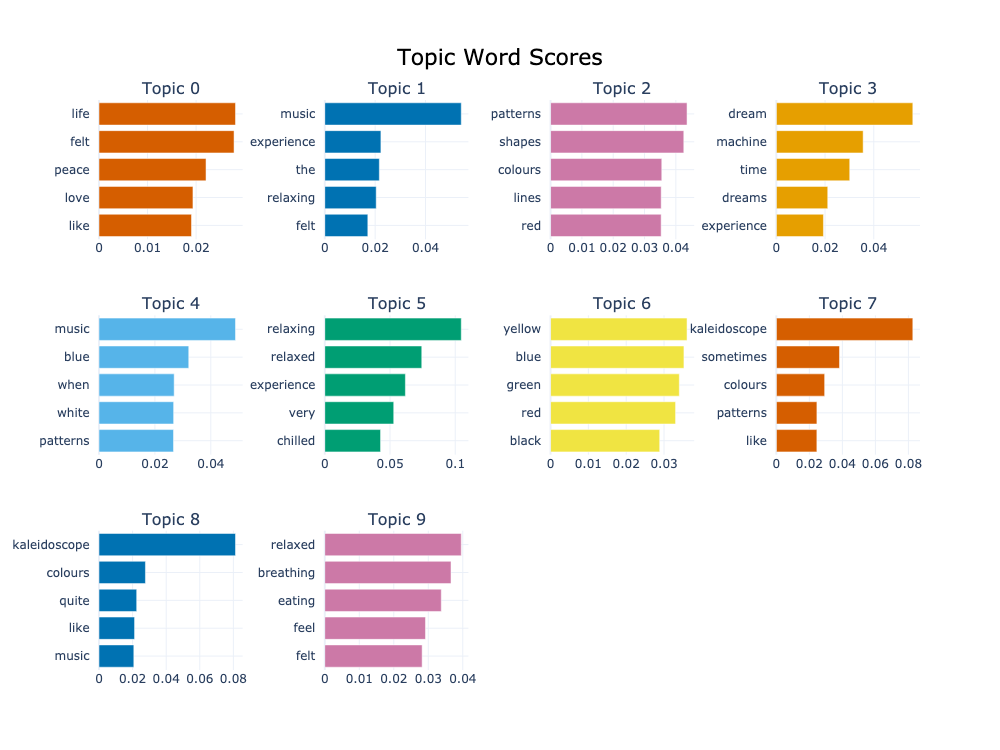

In [339]:
outputs_path = os.path.join(CODEDIR,f'BERT_outputs/{CONDITION}')

# Save the barchart visualization to a file
fig = model.visualize_barchart(top_n_topics=10) #Visualize the top 10 topics
save_path_barchart = os.path.join(outputs_path,'BERT_barchart.png')
fig.write_image(save_path_barchart)

# # Import the Image and display functions from IPython
# from IPython.display import Image, display

# Display the saved image
display(Image(filename=save_path_barchart))

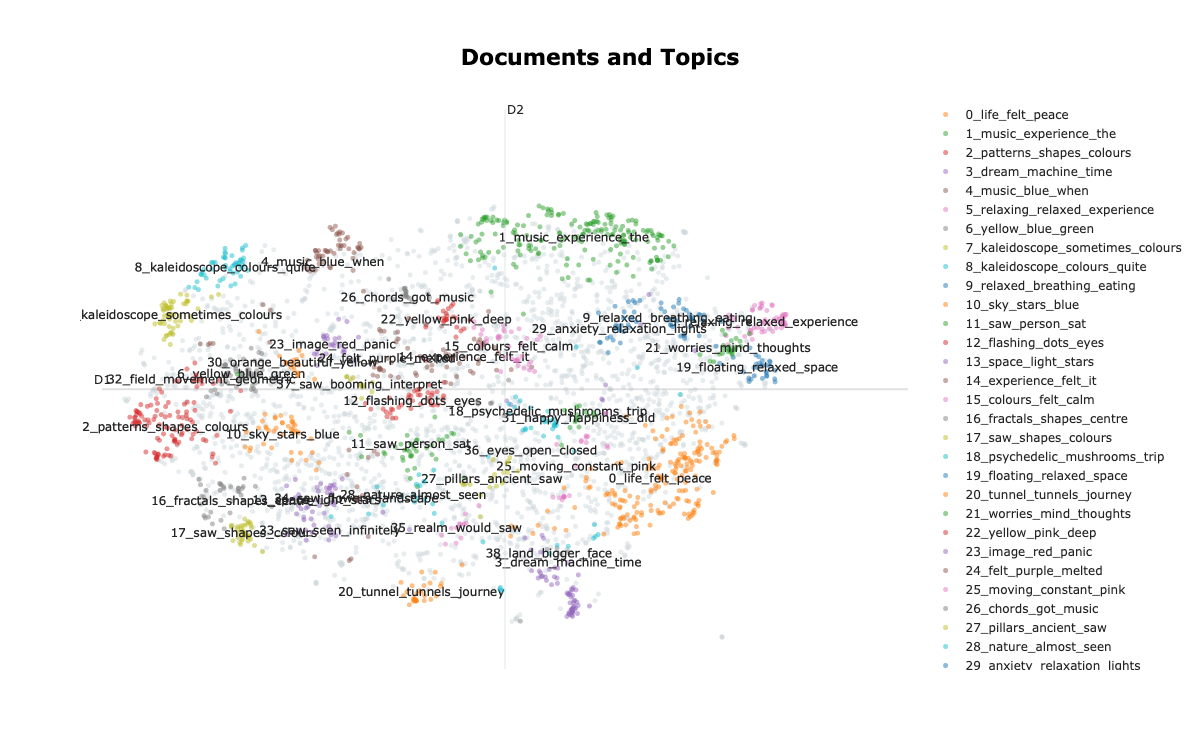

In [340]:
# Save the barchart visualization to a file
fig = model.visualize_documents(reports['reflection_answer'])
save_path_cloud = os.path.join(outputs_path,'BERT_cloud_{}.png'.format(CONDITION))
fig.write_image(save_path_cloud)

# # Import the Image and display functions from IPython
# from IPython.display import Image, display

# Display the saved image
display(Image(filename=save_path_cloud))

In [348]:
model.visualize_heatmap(top_n_topics=10) #Visualize the top 10 topics as a heatmap

In [342]:
# Visualise topic distributions to understand how confident BERTopic is that certain topics can be found in a document
model.visualize_distribution(probs[200], min_probability=0.015)

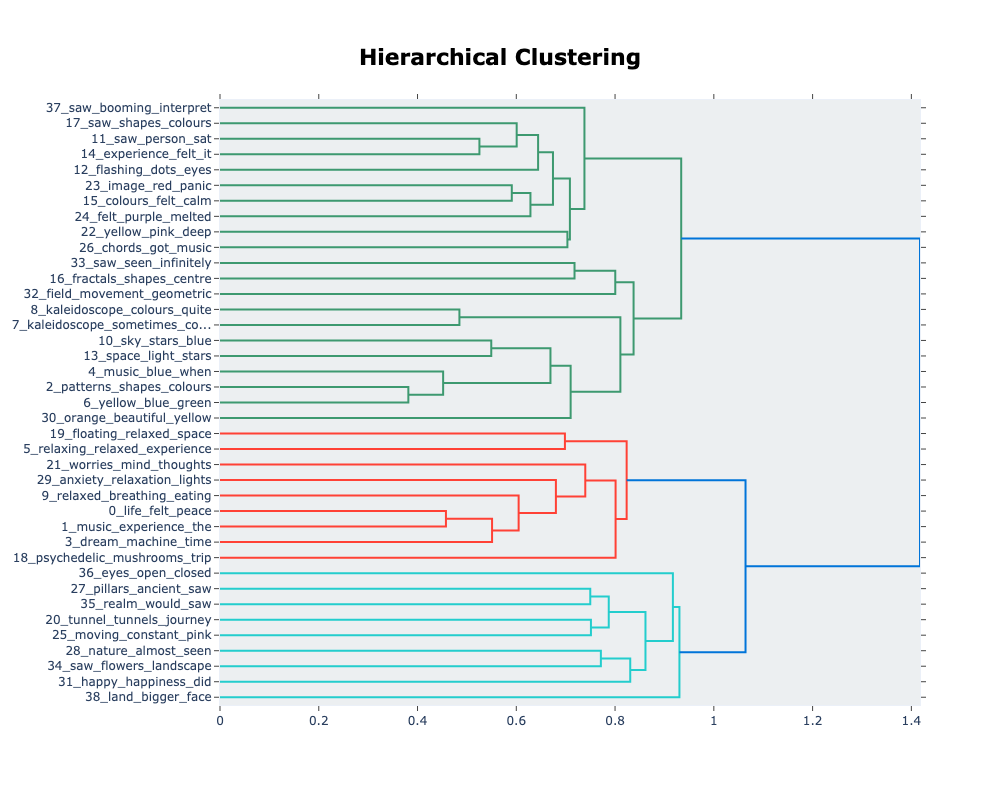

In [343]:

top_n_topics = 50
fig = model.visualize_hierarchy(top_n_topics=top_n_topics)
save_path_cloud = os.path.join(outputs_path,'BERT_hierarchy_{}_top{}topics.png'.format(CONDITION,top_n_topics))
fig.write_image(save_path_cloud)


display(Image(filename=save_path_cloud))

In [345]:
model.visualize_hierarchy(top_n_topics=20,color_threshold=.8)

In [349]:
# List of dimensions assessed in Strobe-ASC Questionnaire :
strobeASC_dimensions = ['unity', 'connectedness','blissful and positive mood', 'insightfulness',
                        'meaningfulness','disembodiement','anxiety', 'complex imagery', 'audio visual synaesthesiae', 
                        'sense of time and space', 'ineffability', 'vigilance reduction']





similar_topics_dict = {}


for dimension in strobeASC_dimensions:
    # Find similar topics
    similar_topics, similarity = model.find_topics(dimension, top_n=3)
    
    # Retrieve topic words for each similar topic
    topic_words_dict = {}
    for i,topic_num in enumerate(similar_topics):
        # Get the words associated with each topic
        words = model.get_topic(topic_num)
        topic_words_dict[topic_num] = {"words":words,"similarity":similarity[i]}
    
    similar_topics_dict[dimension] = {
        "similar_topics": similar_topics,
        "topic_words": topic_words_dict
    }




/var/folders/1d/q_0fy53s0jdcsc1sb09wkntw00z7v7/T/ipykernel_71913/1850452136.py:46: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



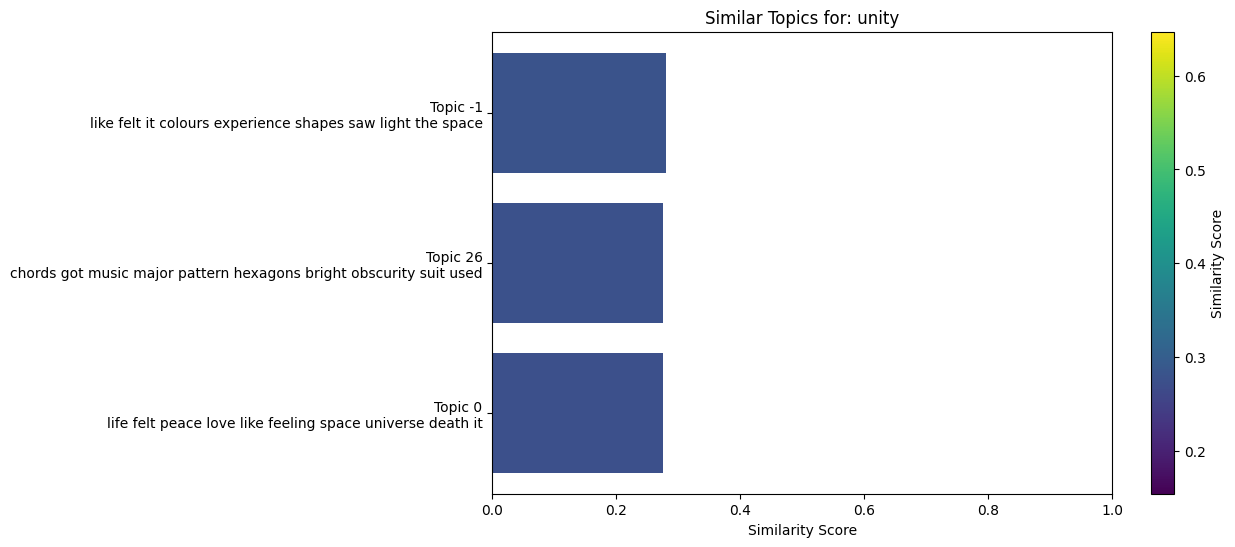

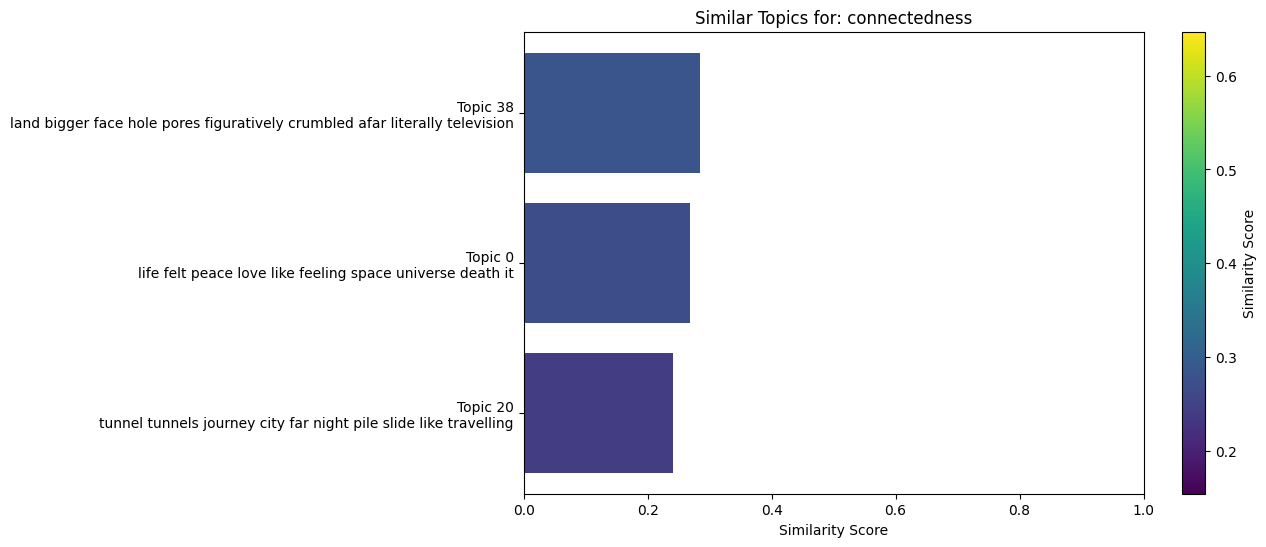

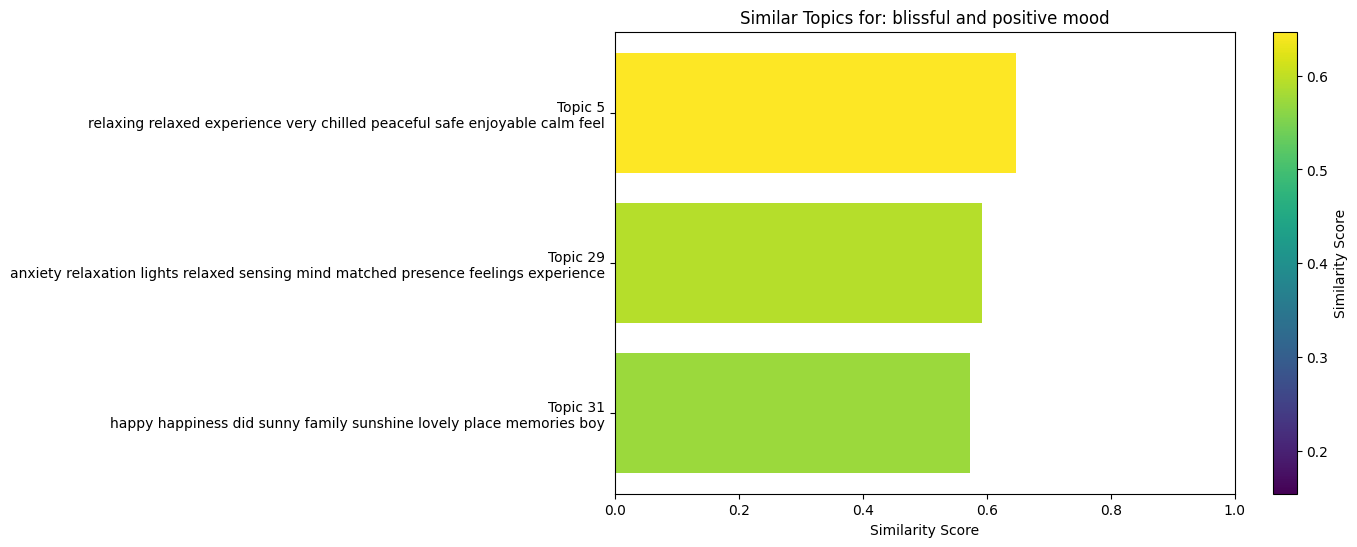

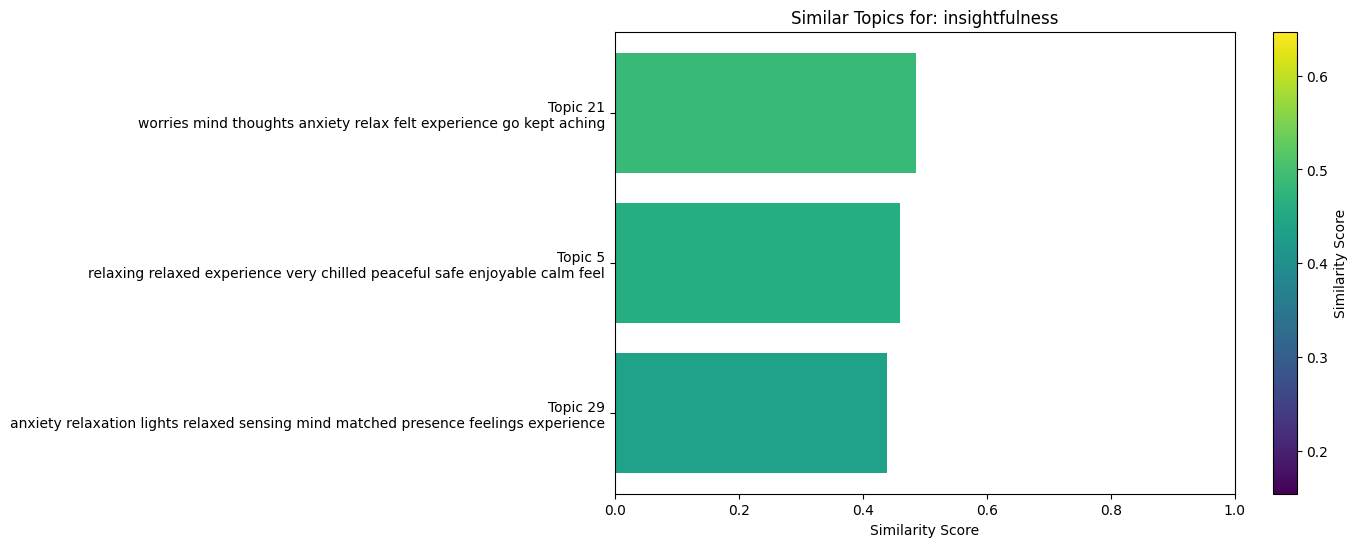

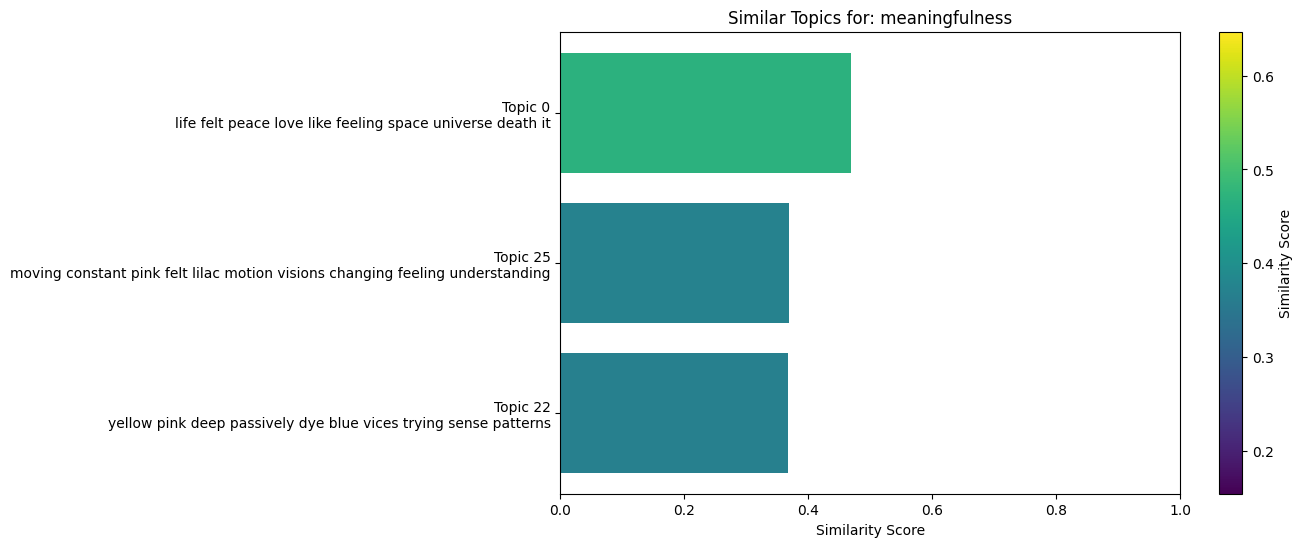

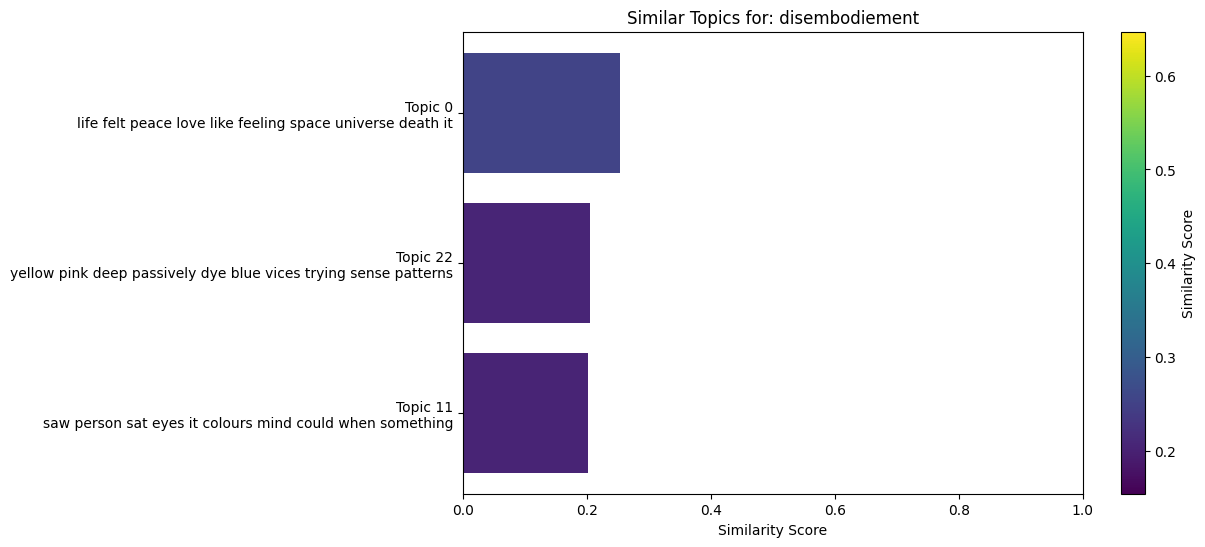

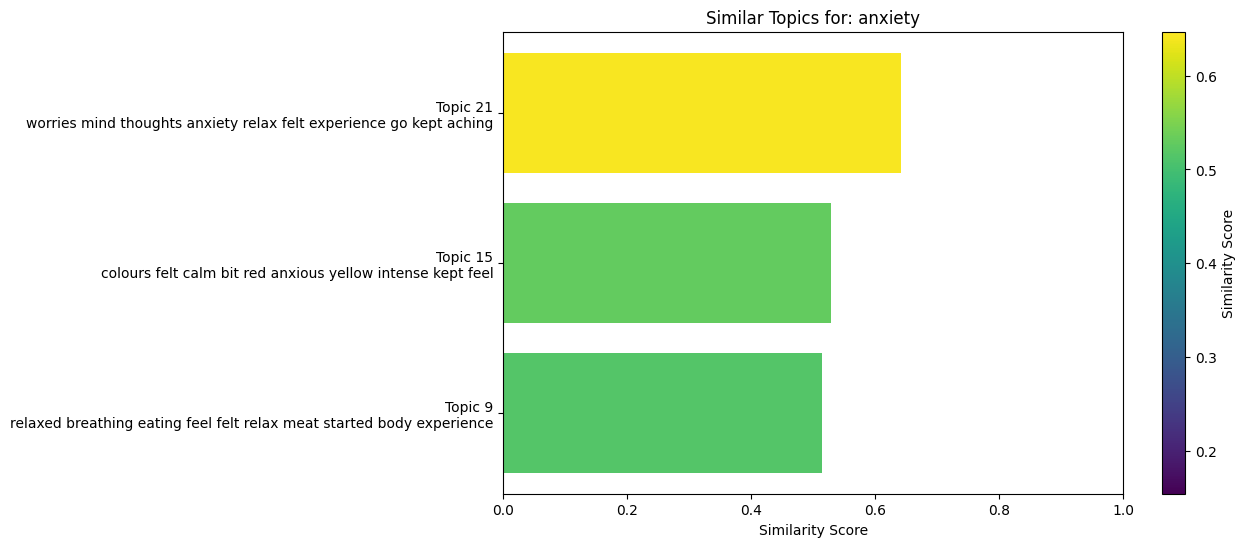

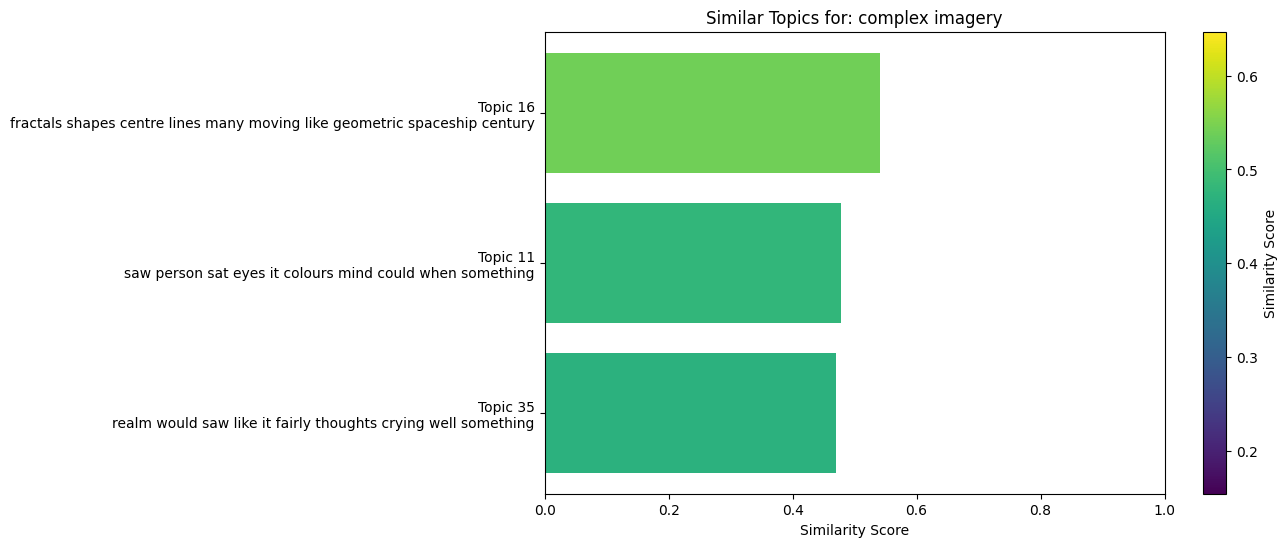

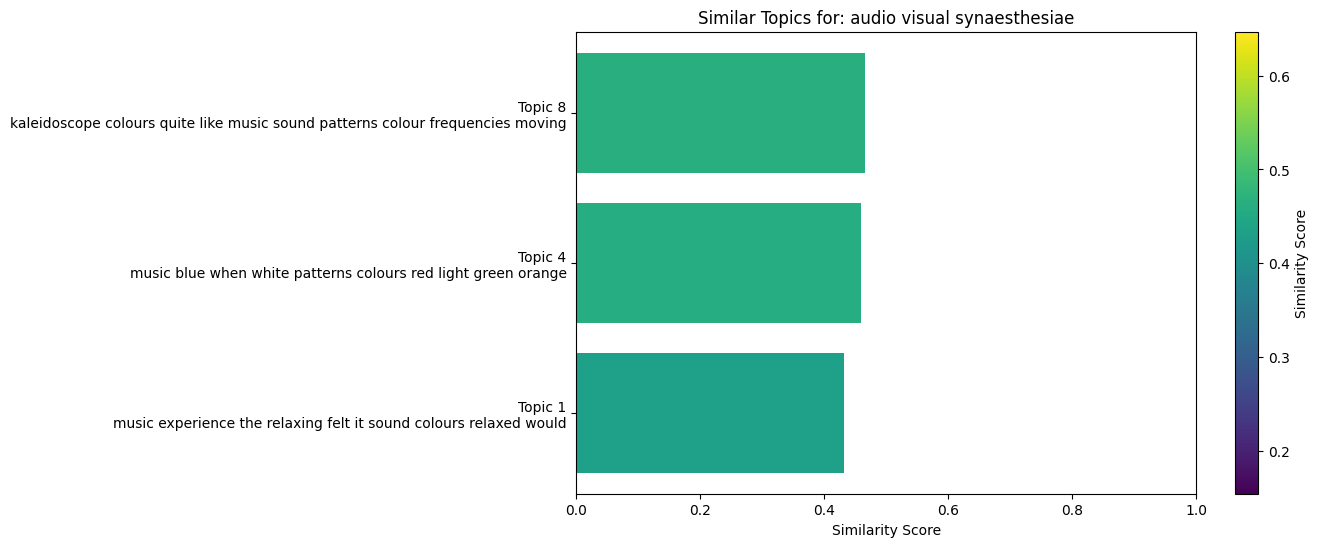

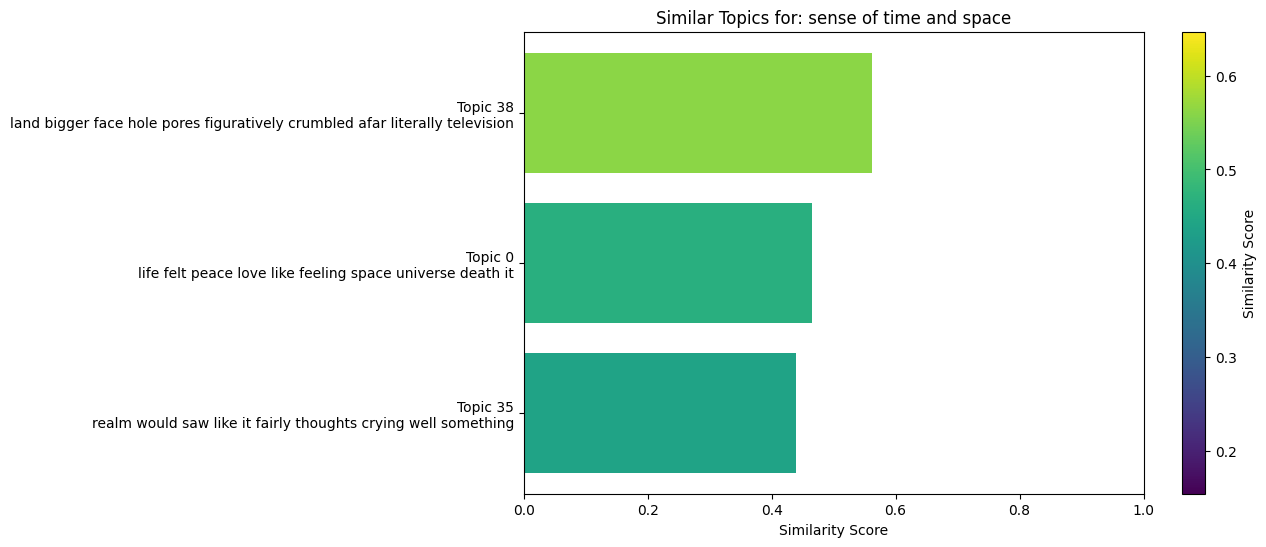

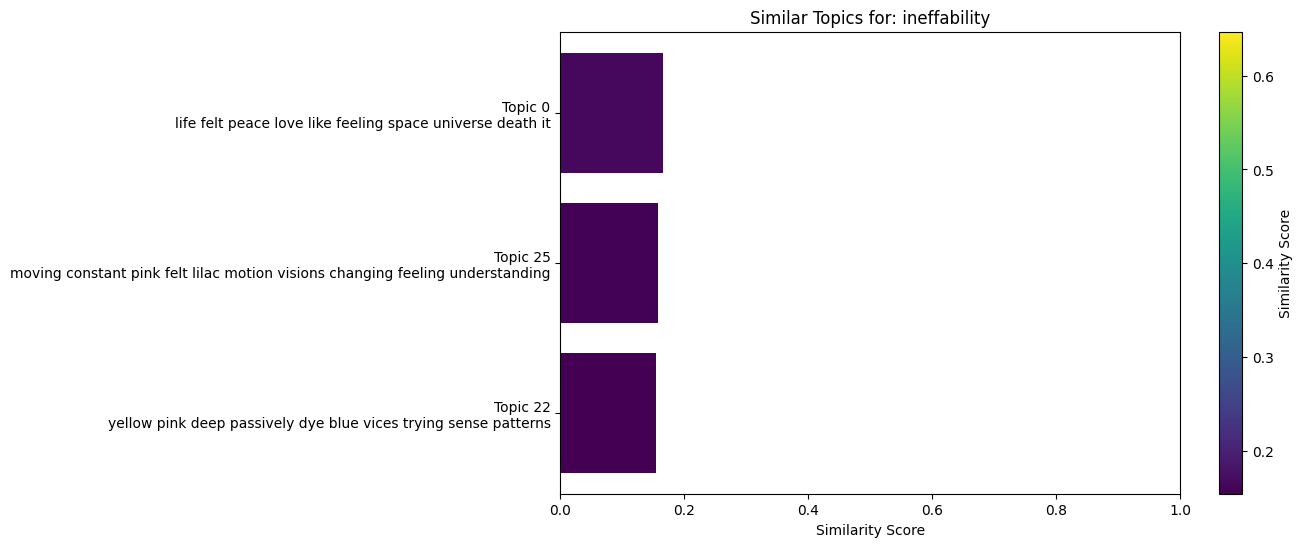

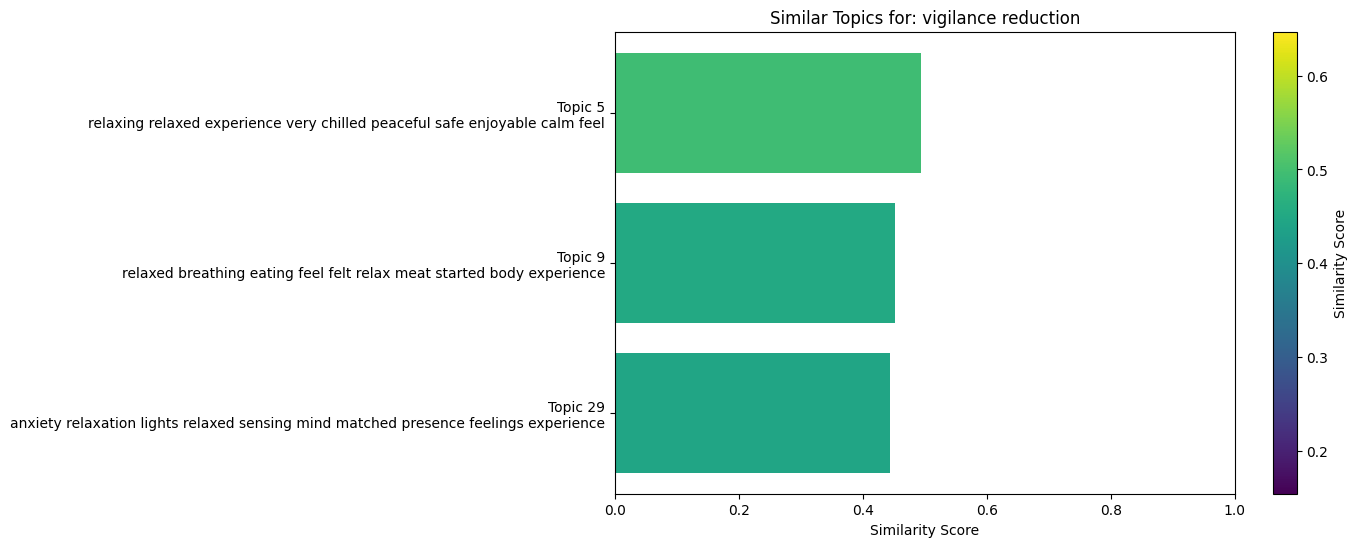

In [351]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def visualize_similar_topics(similar_topics_dict):
    # Find global min and max similarity scores across all dimensions
    all_similarity_scores = [
        topic_info["similarity"] 
        for topics_info in similar_topics_dict.values() 
        for topic_info in topics_info["topic_words"].values()
    ]
    global_min_sim = min(all_similarity_scores)
    global_max_sim = max(all_similarity_scores)
    
    # Create colormap that maps similarity scores to colors
    cmap = matplotlib.colormaps.get_cmap('viridis')
    normalize = mcolors.Normalize(vmin=global_min_sim, vmax=global_max_sim)
    
    for dimension, topics_info in similar_topics_dict.items():
        # Extracting topic numbers and their associated words and similarity
        similar_topics = topics_info["similar_topics"]
        topic_words = topics_info["topic_words"]
        
        # Extracting words for labeling and their corresponding similarity scores
        labels = []
        similarity_scores = []
        for topic_num in similar_topics:
            words = topic_words[topic_num]["words"]
            similarity = topic_words[topic_num]["similarity"]
            labels.append(f"Topic {topic_num}\n{' '.join([word for word, _ in words])}")
            similarity_scores.append(similarity)
        
        # bar chart
        plt.figure(figsize=(10, 6))
        colors = [cmap(normalize(value)) for value in similarity_scores]
        plt.barh(labels, similarity_scores, color=colors)
        plt.xlabel('Similarity Score')
        plt.title(f'Similar Topics for: {dimension}')
        plt.xlim(0, 1)  # Assuming similarity score is between 0 and 1
        plt.gca().invert_yaxis()  # To display the highest score at the top
        
        # colorbar to interpret colors as similarity scores
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
        sm.set_array([])
        plt.colorbar(sm, label='Similarity Score')
        
        plt.show()


visualize_similar_topics(similar_topics_dict)
